# 跟踪算法仿真
## 1. 最小二乘跟踪
&emsp;最小二乘跟踪算法实现比较简单，但是在跟踪之前依赖数据积累，即必须要按照时间维度建立足够长的跟踪队列才能进行跟踪。
<br/>
&emsp;一般跟踪队列越长，则需要更长的时间积累跟踪队列，在跟踪队列填满之后才能开始后续跟踪过程。但是跟踪队列越长，则数据拟合效果越好。跟踪队列长度应该是一个可配置的参数，建议长度为3~5.
<br/>
&emsp;以方位角位列,预测过程如下，俯仰角预测过程和方位角相同：
<br/>
在程序中准备一个FIFO（先入先出队列），队列长度与点数跟踪点数相同。探测设备每返回一个目标方位角，将方位角$\alpha_n$送入队列，并记录对应时间$t_n$，在队列填满后开始进行预测，此时有位置队列及对应时间
$$ 
\begin{align}
&\alpha=\begin{bmatrix}\alpha_1,\alpha_2,\cdots,\alpha_n\end{bmatrix}\\
&t=\begin{bmatrix}t_1,t_2,\cdots,t_n\end{bmatrix} 
\end{align} \tag{1}
$$
根据最小二乘法，预测函数的系数可以用下式进行计算
$$
\begin{equation}Coe=(A^TA)^{-1}A^T*\alpha\end{equation} \tag{2}
$$
对于一次拟合，其预测函数如下:
$$
\begin{equation}\alpha_k=c_1t_k+c_2\end{equation} \tag{3}
$$
对于二次拟合，其预测函数如下：
$$
\begin{equation}\alpha_k=c_1t_k^2+c_2t_k+c_3\end{equation} \tag{4}
$$
对于三次拟合，其预测函数如下：
$$
\begin{equation}\alpha_k=c_1t_k^3+c_2t_k^2+c_3t_k+c_4\end{equation} \tag{5}
$$
对于一次拟合只对于直线运动有比较好的拟合效果，在一般跟踪过程中，更多的使用二次或三次跟踪
<br/>
以二次跟踪为例，在已知跟踪队列长度和队列中各角度的对应时间的情况下可以构建如下矩阵
$$
\begin{equation}
A=\begin{bmatrix}(t_n^T)^2&t_n^T&t_n\end{bmatrix}\begin{bmatrix}t_1^2,&t_1,&1\\
t_2^2,&t_2,&1\\
\vdots\space&\vdots\space&\vdots\\
t_n^2,&t_n,&1
\end{bmatrix}
\end{equation} \tag{6}
$$
之后按照公式（1）计算预测系数后，再根据公式（4）进行预测即可，在预测过程中，注意预测时间，一般使用的时间是下一个周期数据到来的时间。
下面给出最小二乘法的仿真：
这里要注意的是，采用该种方法进行跟踪对俯仰角和方位角要分别建立一个跟踪队列进行维护，因为在这个跟踪系统中，俯仰角和方位角是独立的，并不相关
<br/>
#### a) 参数设置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

tracking_len = 6

#### b) 创建目标

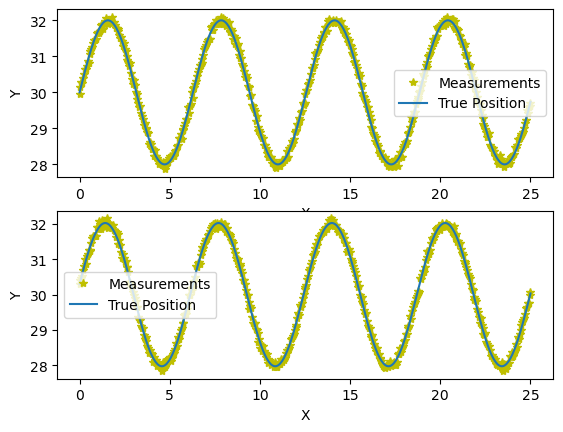

In [2]:
# 生成数据
period = 0.05
length = 500
t = np.linspace(0, length * period, length)
x = t  # x 轴是线性变化
y = 2*np.sin(t) + 30  # y轴为距离,添加一定飞行高度
z = 0.3*np.cos(t)
# 创建一个3D图形对象
fig, ax = plt.subplots(2, 1)
# 添加高斯噪声
mean = 0  # 高斯噪声均值为0
std_val = 0.07  # 标准差为5
noise = np.random.normal(mean, std_val, t.shape)
measurements_y = y + noise
noise = np.random.normal(mean, std_val, t.shape)
measurements_z = y + z + noise
# 绘制三维正弦曲线
ax[0].plot(x, measurements_y, 'y*', label='Measurements')
ax[0].plot(x, y, label='True Position')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()

ax[1].plot(x, measurements_z, 'y*', label='Measurements')
ax[1].plot(x, y + z, label='True Position')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()
# 显示图形
plt.show()

前面的代码按照两个不同坐标轴产生数据，并分别添加观测噪声，之后将两个坐标显示在二维平面上，程序如下
<br/>
#### c) 将坐标进行融合,在二维平面上显示

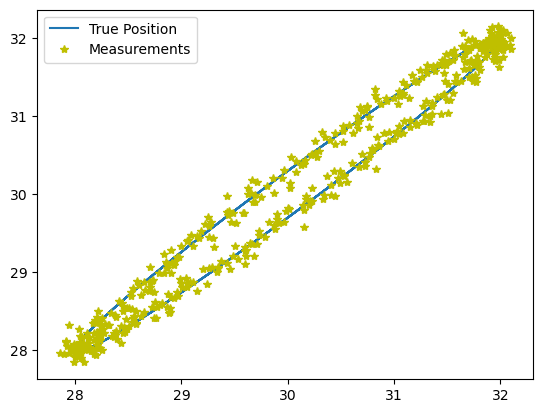

In [3]:
# 将两个坐标融合显示
points = np.vstack((measurements_y, measurements_z))
fig, ax1 = plt.subplots()
ax1.plot(y, y + z, label='True Position')
ax1.plot(points[0], points[1], 'y*', label='Measurements')
ax1.legend()
plt.show()

图中黄色点即为设备探测到的含噪坐标
<br/>
#### d) 创建用于拟合跟踪的类

In [4]:
class QuadFunc_Fitting:

    def __init__(self, tracking_len: int):
        self.tracking_len = tracking_len
        self.measurements_queue = np.zeros(tracking_len)  # 维护一个跟踪队列
        self.time_queue = np.zeros(tracking_len)  # 时间队列
        self.tracking_flg = False
        self.point_cnt = 0  # 计算当前队列长度是否足够

    def gen_time_matrix(self):
        """_summary_
        根据公式(6)创建矩阵
        """
        time_matrix = np.column_stack((self.time_queue**2, self.time_queue, np.ones(self.tracking_len)))
        return time_matrix

    def refresh_tracking_coe(self, time_matrix):
        """_summary_
        根据公式(2)刷新预测参数
        """
        coe = np.dot(
            np.linalg.inv(np.dot(np.transpose(time_matrix), time_matrix)),
            np.dot(np.transpose(time_matrix), self.measurements_queue)
        )
        return coe

    def enqueue(self, measured_point, corresponding_time):
        """_summary_
        刷新跟踪队列和对应的时间,两个都是先入先出队列
        Args:
            measured_point (_type_): 探测到的点的坐标
            corresponding_time (_type_): 探测到的点的对应时间
        """
        self.measurements_queue = np.append(self.measurements_queue[1:], measured_point)
        self.time_queue = np.append(self.time_queue[1:], corresponding_time)

    def tracking(self, measured_point, corresponding_time, pred_time):
        """_summary_
        开始跟踪并刷新跟踪队列和对应的时间
        Args:
            measured_point (_type_): 探测到的点的坐标
            corresponding_time (_type_): 探测到的点的对应时间
        """
        self.enqueue(measured_point, corresponding_time)
        if self.tracking_flg is False:
            self.point_cnt += 1
            if self.point_cnt == self.tracking_len:
                self.tracking_flg = True
        if self.tracking_flg is True:
            time_matrix = self.gen_time_matrix()
            coe = self.refresh_tracking_coe(time_matrix)
            pred = pred_time**2 * coe[0] + pred_time * coe[1] + coe[2]
            return pred
        else:
            return None

    def reset(self):
        """_summary_
        每次跟踪结束后需要将跟踪预测器清空，方便开始进行下次跟踪，如果有
        参数残留在跟踪器里面，会导致结果出错
        """
        self.measurements_queue = np.zeros(self.tracking_len)  # 维护一个跟踪队列
        self.time_queue = np.zeros(self.tracking_len)  # 时间队列
        self.tracking = False
        self.point_cnt = 0

#### e) 开始进行跟踪仿真
尽可能模拟真实情况，每次获取一个目标位置，然后将坐标点分别送入两个预测器进行预测。

In [5]:
predictor_x = QuadFunc_Fitting(tracking_len=tracking_len)
predictor_y = QuadFunc_Fitting(tracking_len=tracking_len) # 创建两个类分别跟踪X坐标和Y坐标
prediction_x = []
prediction_y = [] # 两个队列用来保存预测结果
for i in range(points.shape[1] - 1): # 模拟获取目标结果的过程
    point = points[:, i]
    time = x[i]
    pred_x = predictor_x.tracking(point[0], time, x[i + 1])
    pred_y = predictor_y.tracking(point[1], time, x[i + 1]) # 吐出预测结果
    prediction_x.append(pred_x) 
    prediction_y.append(pred_y) # 为了方便显示效果，将结果存入队列
# 没有探测到目标，跟踪结束
predictor_x.reset()
predictor_y.reset()
x_pred = np.array(prediction_x)
y_pred = np.array(prediction_y)

预测结果绘制如下

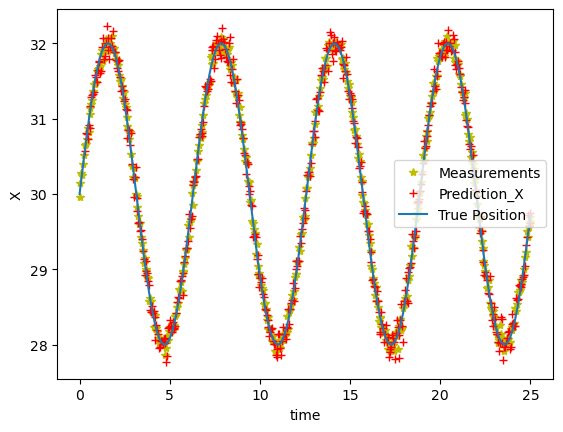

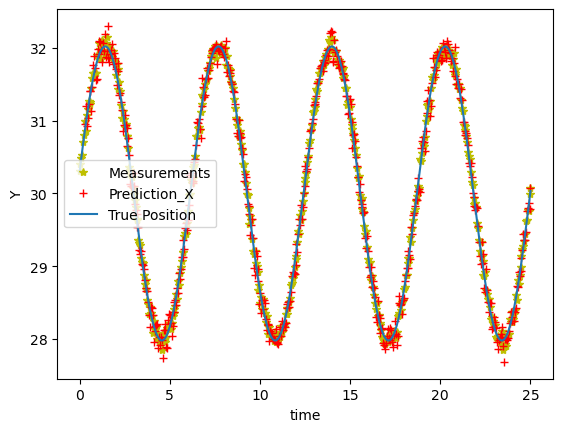

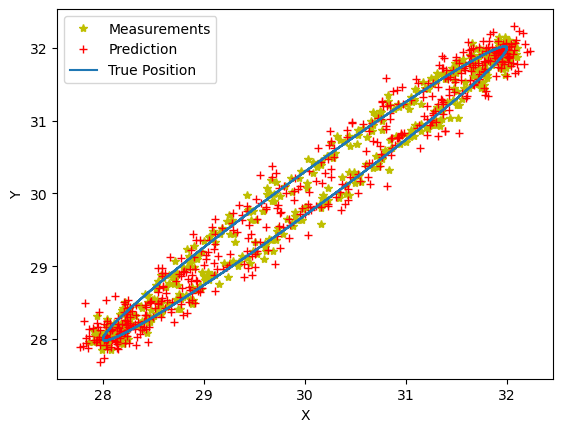

In [6]:
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
fig, ax4 = plt.subplots()
ax2.plot(x, measurements_y, 'y*', label='Measurements')
ax2.plot(x[1:], x_pred, 'r+', label='Prediction_X')
ax2.plot(x, y, label='True Position')
ax2.set_xlabel('time')
ax2.set_ylabel('X')
ax2.legend()
ax3.plot(x, measurements_z, 'y*', label='Measurements')
ax3.plot(x[1:], y_pred, 'r+', label='Prediction_X')
ax3.plot(x, y + z, label='True Position')
ax3.set_xlabel('time')
ax3.set_ylabel('Y')
ax3.legend()
ax4.plot(points[0], points[1], 'y*', label='Measurements')
ax4.plot(x_pred, y_pred, 'r+', label='Prediction')
ax4.plot(y, y + z, label='True Position')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.legend()

## 2. 卡尔曼滤波（Kalman Filter）
卡尔曼滤波是线性滤波，在本跟踪系统中，我们的跟踪设备仅有两个自由度（转台只能调整方位和俯仰），因此跟踪为二维跟踪。处理流程如下
<br/>
1. 将目标初始状态写成矩阵的形式，该矩阵作为目标初始状态矩阵,通过一个变量判断状态矩阵中是否加入加速度
$$
if (!useAcc)\space S=\begin{bmatrix}
\alpha\\
\beta\\
w_{\alpha}\\
w_{\beta}\\
\end{bmatrix} 
\space else \space S=\begin{bmatrix}
\alpha\\
\beta\\
w_{\alpha}\\
w_{\beta}\\
acc_{\alpha}\\
acc_{\beta}
\end{bmatrix}
\tag{7}
$$
其中，$\alpha，\beta$**是目标相对于光电的绝对方位角和俯仰角**，$w_{\alpha},w_{\beta}$是方位角和俯仰角角速度，初始值可以为0，$acc_{\alpha}，acc_{\beta}$是目标角加速度，初始值可以是0。**useAcc唯一可配置参数，如果为真，则在跟踪过程中考虑加速度，如果为假，则在跟踪过程中不考虑加速度，下同**。
<br/>
2. 初始化参数
<br/>
a) 状态转移矩阵
$$
\begin{aligned}if(!useAcc):&T=\begin{bmatrix}1&0&d_t&0\\0&1&0&d_t\\0&0&1&0\\0&0& 0&1\end{bmatrix}\\else:&T=\begin{bmatrix}1&0&d_t&0&\frac{1}{2}d_t^2&0\\0&1&0&d_t&0&\frac{1}{2}d_t^2\\0&0&1&0&d_t&0\\0&0&0&1&0&d_t\\0&0&0&0&1&0\\0&0&0&0&0&1\end{bmatrix}\end{aligned}\tag{8}
$$
其中$d_t$为预测的目标时间，一般为两次观测的时间间隔，这里应该与雷达数据的刷新率一致。
<br/>
b) 观测矩阵
$$
\begin{aligned}if(!useAcc):&H=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}\\else:&H=\begin{bmatrix}1&0&0&0&0&0\\0&1&0&0&0&0\\\end{bmatrix}\end{aligned}\tag{9}
$$
c) 状态协方差矩阵
$$
\begin{aligned}if(!useAcc):&C=\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{bmatrix}\times{CovarVar}\\else:&C=\begin{bmatrix}1&0&0&0&0&0&0\\0&1&0&0&0&0&0\\0&0&1&0&0&0&0\\0&0&0&1&0&0&0\\0&0&0&0&1&0&0\\0&0&0&0&0&1&0\\0&0&0&0&0&0&1\end{bmatrix}\times{CovarVar}\end{aligned} \tag{10}
$$
d) 过程噪声协方差矩阵
$$
\begin{aligned}if(!useAcc):&Q=\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{bmatrix}\times{PredVar}\\else:&Q=\begin{bmatrix}1&0&0&0&0&0&0\\0&1&0&0&0&0&0\\0&0&1&0&0&0&0\\0&0&0&1&0&0&0\\0&0&0&0&1&0&0\\0&0&0&0&0&1&0\\0&0&0&0&0&0&1\end{bmatrix}\times{PredVar}\end{aligned} \tag{11}
$$
e) 观测噪声协方差矩阵
$$
R=\begin{bmatrix}1&0\\0&1\end{bmatrix}\times{ObserVar} \tag{12}
$$
3. 刷新参数
在雷达每次探测到数据之后，将目标俯仰角和方位角映射到光电坐标系下，具体映射关系参考第二节。之后按照如下公式进行刷新。**注意，所有的乘法均为矩阵乘法和实数乘法，不会使用叉乘和点乘**。
$$
\begin{aligned}
&Prediction=T*S\\
&P_r=S*C*S^T+Q\\
&K=(P_r*H^T)/(H*P_r*H^T+R)\\
&S_{refreshed}=Prediction+K*(S-H*Prediction)\\
&C_{refreshed }=(I-K*H)*P_r
\end{aligned} \tag{13}
$$
使用卡尔曼滤波进行跟踪仿真，当前已经得到目标点了，直接创建卡尔曼滤波类
#### a) 参数设定


In [7]:
use_acc = False  # 状态矩阵是否包含加速度
covar_val = 1  # 协方差初始值
process_var = 0.3  # 过程噪声系数
observing_var = 0.5  # 观测噪声系数

#### b) 创建跟踪类

In [8]:
class KalmanFilter:

    def __init__(self, useAcc: bool, covar_val: float, process_var: float, observing_var: float, d_t):
        self.useAcc = useAcc
        self.covar_val = covar_val
        self.process_var = process_var
        self.observing_var = observing_var
        self.d_t = d_t
        self.pred_state = np.array([])
        self.__initial_data()

    def __initial_data(self):
        """
        根据公式(8)~(11)初始化参数
        """
        if self.useAcc is True:
            self.A = np.array([[1, 0, self.d_t, 0, 0.5 * self.d_t**2, 0], [0, 1, 0, self.d_t, 0, 0.5 * self.d_t**2],
                               [0, 0, 1, 0, self.d_t, 0], [0, 0, 0, 1, 0, self.d_t], [0, 0, 0, 0, 1, 0],
                               [0, 0, 0, 0, 0, 1]])
            self.H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
            self.process_mat = np.eye(6) * self.process_var
            self.observe_mat = np.eye(2) * self.observing_var
            self.covariance_mat = np.eye(6) * self.covar_val
            self.unit_mat = np.eye(6)
        else:
            self.A = np.array([[1, 0, self.d_t, 0], [0, 1, 0, self.d_t], [0, 0, 1, 0], [0, 0, 0, 1]])
            self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
            self.process_mat = np.eye(4) * self.process_var
            self.observe_mat = np.eye(2) * self.observing_var
            self.covariance_mat = np.eye(4) * self.covar_val
            self.unit_mat = np.eye(4)

    def __state_transition(self):
        """_summary_
        利用状态转移矩阵进行预测，预测原理非常简单，就是很简单的物理公式
        位移等于速度乘以时间
        Returns:
            np.array: 目标预测状态
        """
        prediction = self.A @ self.pred_state
        return prediction

    def tracking(self, measurement):
        """
        根据公式(13)刷新跟踪参数，由于系统不具备初始状态，因此获取到的
        第一个观测值作为初始状态，初始状态的速度可以为0，之后通过反复迭代
        来跟新目标速度。
        Args:
            measurement (_type_): 目标观测值

        Returns:
            np.array: 预测的目标位置 
        """
        if self.pred_state.size == 0:
            self.pred_state = np.transpose(np.concatenate((measurement, np.array([0, 0]))))
            prediction = self.__state_transition()
            print(prediction)
            self.pred_state = prediction
            self.covariance_mat = self.A * self.covariance_mat * np.transpose(self.A) + self.process_mat
            return self.pred_state
        prediction = self.__state_transition()
        p_refresh = self.A @ self.covariance_mat @ np.transpose(self.A) + self.process_mat
        K = (p_refresh @ np.transpose(self.H)) @ np.linalg.inv(self.H @ p_refresh @ np.transpose(self.H) + self.observe_mat)
        self.pred_state = prediction + K @ (measurement - self.H @ prediction)
        self.covariance_mat = (self.unit_mat - K @ self.H) @ p_refresh
        return self.pred_state
    
    def reset(self):
        self.__initial_data()
        self.pred_state = np.array([])

#### c) 进行跟踪仿真

声明追踪预测器

In [9]:
predictor = KalmanFilter(useAcc=use_acc, covar_val=covar_val, process_var=process_var, observing_var=observing_var, d_t=x[1]-x[0])

模拟实际情况，每个采样时间获取一次目标位置，进行跟踪预测

In [10]:
prediction = []
for i in range(points.shape[1] - 1): # 模拟获取目标结果的过程
    point = points[:, i]
    time = x[i]
    pred = predictor.tracking(point)
    prediction.append(pred[:2]) 
predictor.reset()

[29.96220287 30.31162627  0.          0.        ]


将追踪结果绘制成跟踪曲线

Text(0, 0.5, 'Y')

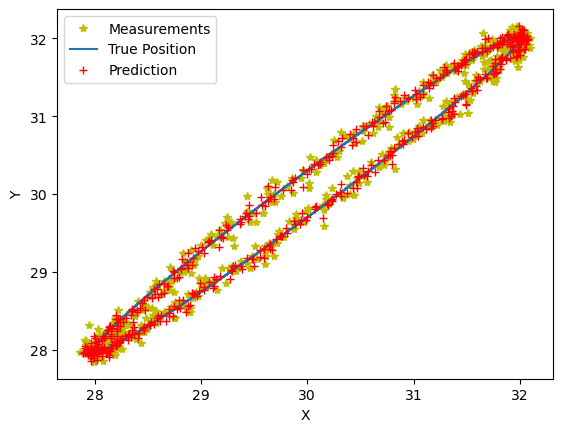

In [11]:
fig, ax5 = plt.subplots()
prediction_mat = np.array(prediction)
ax5.plot(points[0], points[1], 'y*', label='Measurements')
ax5.plot(y, y + z, label='True Position')
ax5.plot(prediction_mat[:,0], prediction_mat[:,1], 'r+', label='Prediction')
ax5.legend()
ax5.set_xlabel("X") # X坐标
ax5.set_ylabel("Y") # Y坐标

## 3. 扩展卡尔曼滤波
扩展卡尔曼滤波原理与卡尔曼滤波类似，主要应用于非线性运动的跟踪。其目标状态由目标位置，线速度，滚转角，滚转角速度组成。具体处理流程如下： 
<br/>
1. 将目标初始状态写为矩阵形式
$$
S=\begin{bmatrix}\alpha\\\beta\\v\\\theta\\\omega\tag{14}\end{bmatrix}
$$
其中.$\alpha，\beta$为目标在光电坐标系下的方位角和俯仰角，v为目标在俯仰角和方位角两个维度上角速度的矢量和，$\theta$为目标航向角，$\omega$为目标的转向速度。除了$\alpha，\beta$外，其余参数可以初始化为0。
<br/>
2. 初始化参数
<br/>
a) 状态转移过程如下
$$
S_{k+1}=\begin{bmatrix}\alpha_{k+1}\\\beta_{k+1}\\v_{k+1}\\\theta_{k+1}\\\omega_{k+1}\end{bmatrix}=\begin{bmatrix}\alpha_{k}+\frac{v_k}{\omega_k}(\sin{(\theta_k+\omega_kd_t)}-\sin(\theta_k))\\\beta+\frac{v_k}{\omega_k}(\cos(\theta_k)-\cos(\theta_k+\omega_kd_t))\\v_k\\\theta_k+\omega_kd_t\\\omega_t\tag{15}\end{bmatrix}
$$
根据状态转移过程计算状态转移过程的雅可比矩阵
$$
\begin{aligned}F_k&=\begin{bmatrix}\frac{\partial{\alpha_{k+1}}}{\partial{\alpha_k}}&\frac{\partial{\alpha_{k+1}}}{\partial{\beta_k}}&\frac{\partial{\alpha_{k+1}}}{\partial{v_k}}&\frac{\partial{\alpha_{k+1}}}{\partial{\theta_k}}&\frac{\partial{\alpha_{k+1}}}{\partial{\omega_k}}\\\frac{\partial{\beta_{k+1}}}{\partial{\alpha_k}}&\frac{\partial{\beta_{k+1}}}{\partial{\beta_k}}&\frac{\partial{\beta_{k+1}}}{\partial{v_k}}&\frac{\partial{\beta_{k+1}}}{\partial{\theta_k}}&\frac{\partial{\beta_{k+1}}}{\partial{\omega_k}}\\\frac{\partial{v_{k+1}}}{\partial{\alpha_k}}&\frac{\partial{v_{k+1}}}{\partial{\beta_k}}&\frac{\partial{v_{k+1}}}{\partial{v_k}}&\frac{\partial{v_{k+1}}}{\partial{\theta_k}}&\frac{\partial{v_{k+1}}}{\partial{\omega_k}}\\\frac{\partial{\theta_{k+1}}}{\partial{\alpha_k}}&\frac{\partial{\theta_{k+1}}}{\partial{\beta_k}}&\frac{\partial{\theta_{k+1}}}{\partial{v_k}}&\frac{\partial{\theta_{k+1}}}{\partial{\theta_k}}&\frac{\partial{\theta_{k+1}}}{\partial{\omega_k}}\\\frac{\partial{\omega_{k+1}}}{\partial{\alpha_k}}&\frac{\partial{\omega_{k+1}}}{\partial{\beta_k}}&\frac{\partial{\omega_{k+1}}}{\partial{v_k}}&\frac{\partial{\omega_{k+1}}}{\partial{\theta_k}}&\frac{\partial{\omega_{k+1}}}{\partial{\omega_k}}\end{bmatrix}\\&=\begin{bmatrix}1&0&\frac{\sin{(\theta_k+\omega_kd_t)-\sin{(\theta_k)}}}{\omega_k}&\frac{v_k}{\omega_k}(\cos{(\theta_k+\omega_kd_t)-\cos{(\theta_k)}})&\frac{v_k}{\omega_k^2}(\sin{(\theta_k)-\sin(\theta_k+\omega_kd_t)})+\frac{v_k}{\omega_k}d_t\cos{(\theta_k+\omega_kd_t)}\\0&1&\frac{\cos{(\theta_k)-\cos{(\theta_k+\omega_kd_t)}}}{\omega_k}&\frac{v_k}{\omega_k}(\sin{(\theta_k+\omega_kd_t)}-\sin(\theta_k))&\frac{v_k}{\omega_k^2}(\cos{(\theta_k+\omega_kd_t)}-\cos{(\theta_k)})+\frac{v_k}{\omega_k}d_t\sin{(\theta_k+\omega_kd_t)}\\0&0&1&0&0\\0&0&0&1&d_t\\0&0&0&0&1\tag{16}\end{bmatrix}\end{aligned}
$$
b) 观测矩阵
$$
H=\begin{bmatrix}1&0&0&0&0\\0&1&0&0&0\end{bmatrix}\tag{17}
$$
c) 协方差矩阵
$$
C=\begin{bmatrix}1&0&0&0&0\\0&1&0&0&0\\0&0&1&0&0\\0&0&0&1&0\\0&0&0&0&1\end{bmatrix}*CovarVar\tag{18}
$$
d) 过程噪声协方差矩阵
$$
Q=\begin{bmatrix}1&0&0&0&0\\0&1&0&0&0\\0&0&1&0&0\\0&0&0&1&0\\0&0&0&0&1\end{bmatrix}*PredVar\tag{19}
$$
e) 观测噪声协方差矩阵
$$
R=\begin{bmatrix}1&0\\0&1\end{bmatrix}\times{ObserVar}\tag{20}
$$
$d_t$与卡尔曼滤波中的定义一样。
<br\>
3. 刷新参数
这里刷新参数过程与卡尔曼滤波一样，区别在于刷新公式有一点区别，刷新公式如下
$$
\begin{aligned}&Prediction=S_{k+1}=\begin{bmatrix}\alpha_{k+1}\\\beta_{k+1}\\v_{k+1}\\\theta_{k+1}\\\omega_{k+1}\end{bmatrix}=\begin{bmatrix}\alpha_{k}+\frac{v_k}{\omega_k}(\sin{(\theta_k+\omega_kd_t)}-\sin(\theta_k))\\\beta+\frac{v_k}{\omega_k}(\cos(\theta_k)-\cos(\theta_k+\omega_kd_t))\\v_k\\\theta_k+\omega_kd_t\\\omega_t\end{bmatrix}\\&P_r=F_k*C*F_k^T+Q\\&K=(Pr*H^T)/(H*P_r*H^T+R)\\&S_{refreshed}=Prediction+K(\begin{bmatrix}\alpha_k\\\beta_k\end{bmatrix}-H*Prediction)\\&C_{refreshed}=(I-K*H)P_r\end{aligned}\tag{21}
$$
对扩展卡尔曼滤波跟踪进行仿真，使用与前述仿真相同的坐标点。
#### a) 参数设置

In [12]:
covar_val = 1  # 协方差初始值
process_var = 0.3  # 过程噪声系数
observing_var = 0.5  # 观测噪声系数

#### b) 创建跟踪类

In [13]:
class EKFilter:

    def __init__(self, covar_val: float, process_var: float, observing_var: float, d_t):
        self.covar_val = covar_val
        self.process_var = process_var
        self.observing_var = observing_var
        self.d_t = d_t
        self.pred_state = np.array([])
        self.__initial_data()

    def __initial_data(self):
        """
        根据公式(8)~(11)初始化参数
        """
        self.H = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
        self.process_mat = np.eye(5) * self.process_var
        self.observe_mat = np.eye(2) * self.observing_var
        self.covariance_mat = np.eye(5) * self.covar_val
        self.unit_mat = np.eye(5)

    def __state_transition(self):
        """_summary_
        利用状态转移矩阵进行预测，预测原理非常简单，就是很简单的物理公式
        位移等于速度乘以时间
        Returns:
            np.array: 目标预测状态
        """
        x_pos = self.pred_state[0]
        y_pos = self.pred_state[1]
        v = self.pred_state[2]
        theta = self.pred_state[3]
        omega = self.pred_state[4]

        if np.abs(omega) > 1e-5:
            x_pos_new = x_pos + v / omega * (np.sin(theta + omega * self.d_t) - np.sin(theta))
            y_pos_new = y_pos + v / omega * (np.cos(theta) - np.cos(theta + omega * self.d_t))
        else:
            x_pos_new = x_pos + v * self.d_t * np.cos(theta)
            y_pos_new = y_pos + v * self.d_t * np.sin(theta)

        theta_new = theta + omega * self.d_t

        return np.array([x_pos_new, y_pos_new, v, theta_new, omega])

    def __jacobian(self):
        v = self.pred_state[2]
        theta = self.pred_state[3]
        omega = self.pred_state[4]

        if np.abs(omega) > 1e-5:
            F = np.array([[
                1, 0, (np.sin(theta + omega * self.d_t) - np.sin(theta)) / omega,
                v * (np.cos(theta + omega * self.d_t) - np.cos(theta)) / omega,
                v * (np.sin(theta) - np.sin(theta + omega * self.d_t)) / omega**2 +
                v * self.d_t * np.cos(theta + omega * self.d_t) / omega
            ],
                          [
                              0, 1, (np.cos(theta) - np.cos(theta + omega * self.d_t)) / omega,
                              v * (np.sin(theta + omega * self.d_t) - np.sin(theta)) / omega,
                              v * (np.cos(theta + omega * self.d_t) - np.cos(theta)) / omega**2 +
                              v * self.d_t * np.sin(theta + omega * self.d_t) / omega
                          ], [0, 0, 1, 0, 0], [0, 0, 0, 1, self.d_t], [0, 0, 0, 0, 1]])
        else:
            F = np.array([[1, 0, np.float64(self.d_t * np.cos(theta)), np.float64(-v * self.d_t * np.sin(theta)), 0],
                          [0, 1, np.float64(self.d_t * np.sin(theta)), np.float64(v * self.d_t * np.cos(theta)), 0], [0, 0, 1, 0, 0],
                          [0, 0, 0, 1, self.d_t], [0, 0, 0, 0, 1]])

        return F

    def tracking(self, measurement):
        """
        根据公式(13)刷新跟踪参数，由于系统不具备初始状态，因此获取到的
        第一个观测值作为初始状态，初始状态的速度可以为0，之后通过反复迭代
        来跟新目标速度。
        Args:
            measurement (_type_): 目标观测值

        Returns:
            np.array: 预测的目标位置 
        """
        if self.pred_state.size == 0:
            self.pred_state = np.transpose(np.concatenate((measurement, np.array([0, 0, 0]))))
            F = self.__jacobian()
            prediction = self.__state_transition()
            self.pred_state = prediction
            self.covariance_mat = F * self.covariance_mat * np.transpose(F) + self.process_mat
            return self.pred_state
        prediction = self.__state_transition()
        F = self.__jacobian()
        p_refresh = F @ self.covariance_mat @ np.transpose(F) + self.process_mat
        K = (p_refresh @ np.transpose(self.H
                                     )) @ np.linalg.inv(self.H @ p_refresh @ np.transpose(self.H) + self.observe_mat)
        self.pred_state = prediction + K @ (measurement - self.H @ prediction)
        self.covariance_mat = (self.unit_mat - K @ self.H) @ p_refresh
        return self.pred_state

    def reset(self):
        """_summary_
        清空前一次跟踪所残留的参数
        """
        self.__initial_data()
        self.pred_state = np.array([])

#### c) 进行跟踪仿真
声明跟踪器

In [14]:
ekf_predictor = EKFilter(covar_val=covar_val, process_var=process_var, observing_var=observing_var, d_t=x[1]-x[0])

模拟实际情况，每个采样时间获取一次目标位置，进行跟踪预测

In [15]:
prediction = []
for i in range(points.shape[1] - 1): # 模拟获取目标结果的过程
    point = points[:, i]
    time = x[i]
    pred = ekf_predictor.tracking(point)
    prediction.append(pred[:2]) 
ekf_predictor.reset()

将追踪结果绘制成跟踪曲线

Text(0, 0.5, 'Y')

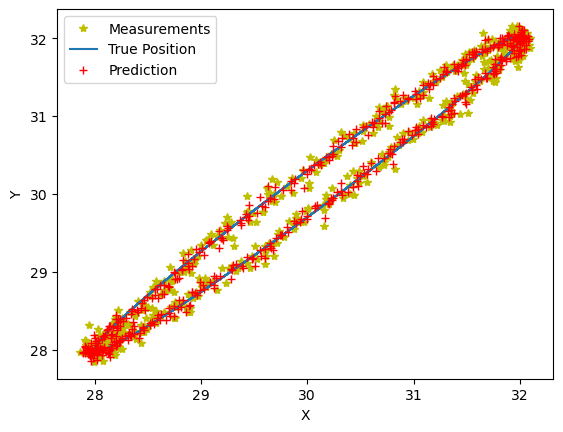

In [16]:
fig, ax5 = plt.subplots()
prediction_mat = np.array(prediction)
ax5.plot(points[0], points[1], 'y*', label='Measurements')
ax5.plot(y, y + z, label='True Position')
ax5.plot(prediction_mat[:,0], prediction_mat[:,1], 'r+', label='Prediction')
ax5.legend()
ax5.set_xlabel("X") # X坐标
ax5.set_ylabel("Y") # Y坐标